In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore")
# warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10, 6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

from warnings import simplefilter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from os.path import exists
simplefilter('ignore')
SEED = 41
np.random.seed(SEED)

if not exists ('/kaggle/input/used-car-price-prediction-competition'):
    base_path = ('/kaggle/input/used-car-price-prediction-competition2')
else:
    base_path = ('/kaggle/input')

train = pd.read_csv(base_path + '/train.csv', index_col=0)
test = pd.read_csv(base_path + '/test.csv', index_col=0)
submission = pd.read_csv(base_path + '/Sample_Submition.csv')

/kaggle/input/used-car-price-prediction-competition2/Sample_Submition.csv
/kaggle/input/used-car-price-prediction-competition2/train.csv
/kaggle/input/used-car-price-prediction-competition2/test.csv


In [3]:
# import numpy as np
# import pandas as pd

def reduce_mem_usage(df):
    """ Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'object' or col_type.name == 'category':
#             df[col] = df[col].astype('category')
            continue
        elif np.issubdtype(col_type, np.integer):
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
        elif np.issubdtype(col_type, np.floating):
            df[col] = pd.to_numeric(df[col], downcast='float')
    
    # Explicitly handle datetime columns with timezone
    datetime_cols_with_tz = [col for col in df.columns if df[col].dtype == 'datetime64[ns, tz]']
    for col in datetime_cols_with_tz:
        df[col] = df[col].dt.tz_localize(None)  # Remove timezone information
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
import gc

# df = pd.read_csv("path of your dataset")
# df = reduce_mem_usage(df)


train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

gc.collect()

Memory usage of dataframe is 226.58 MB
Memory usage after optimization is: 222.16 MB
Decreased by 2.0%
Memory usage of dataframe is 96.14 MB
Memory usage after optimization is: 94.24 MB
Decreased by 2.0%


0

### Train Set

In [5]:
train.head()

,id,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date,price
121610,7309831550,2007.000,infiniti,m45,excellent,NaN,gas,214740.000,clean,automatic,rwd,NaN,sedan,black,ga,34.140,-83.971,2021-04-20T11:46:13-0400,7995
395646,7317007429,2008.000,cadillac,escalade,NaN,NaN,gas,170276.000,clean,automatic,NaN,NaN,SUV,black,wa,47.757,-122.212,2021-05-04T16:16:32-0700,14999
236366,7309202024,2003.000,lexus,es,NaN,NaN,gas,176910.000,clean,automatic,fwd,NaN,sedan,NaN,nc,34.210,-77.844,2021-04-19T10:07:58-0400,5995
66001,7306341714,2017.000,bmw,320i,excellent,NaN,gas,41000.000,clean,automatic,4wd,NaN,SUV,NaN,ca,33.811,-117.849,2021-04-13T13:05:06-0700,0
320855,7307880118,2008.000,toyota,rav4,good,6 cylinders,gas,138900.000,clean,automatic,4wd,full-size,SUV,silver,pa,40.144,-76.597,2021-04-16T15:22:02-0400,7995


In [6]:
train.describe()

,id,year,odometer,lat,long,price
count,290129.000,290129.000,290129.000,285726.000,285726.000,290129.000
mean,7311503279.059,2011.359,97642.414,38.506,-94.616,51933.002
std,4378450.259,9.149,205897.016,5.830,18.319,9591680.313
min,7301583321.000,1900.000,0.000,-84.122,-159.828,0.000
25%,7308154295.000,2008.000,38000.000,34.600,-111.925,5991.000
50%,7312664164.000,2014.000,85615.000,39.170,-88.212,13990.000
75%,7315255273.000,2017.000,133436.000,42.408,-80.830,26500.000
max,7317101084.000,2022.000,10000000.000,82.253,173.885,3736928711.000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290129 entries, 121610 to 305711
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            290129 non-null  int64  
 1   year          290129 non-null  float32
 2   manufacturer  278787 non-null  object 
 3   model         290129 non-null  object 
 4   condition     174025 non-null  object 
 5   cylinders     170829 non-null  object 
 6   fuel          288676 non-null  object 
 7   odometer      290129 non-null  float32
 8   title_status  285063 non-null  object 
 9   transmission  290129 non-null  object 
 10  drive         202042 non-null  object 
 11  size          82445 non-null   object 
 12  type          227533 non-null  object 
 13  paint_color   203016 non-null  object 
 14  state         290129 non-null  object 
 15  lat           285726 non-null  float32
 16  long          285726 non-null  float32
 17  posting_date  290129 non-null  object 
 18 

In [8]:
train.drop(columns=["id", "state", "posting_date", "lat", "long"]).duplicated().sum()

108551

In [9]:
col_check = ['year', 'manufacturer', 'model', 'cylinders', 'fuel',
       'odometer', 'transmission', 'drive', 'size', 'type','price']

# Create a boolean mask for duplicated rows based on the specified columns
dupli_mask = train.duplicated(subset=col_check)

# Select the duplicated rows and display two instances of each
dupli_rows = train[dupli_mask]

dupli_rows

,id,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date,price
14689,7314527323,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,az,32.210,-110.960,2021-04-29T14:11:18-0700,37590
335386,7311934099,2015.000,mercedes-benz,m-class,NaN,6 cylinders,gas,95900.000,clean,automatic,4wd,mid-size,SUV,white,sc,NaN,NaN,2021-04-24T13:09:04-0400,0
27860,7305693888,2016.000,NaN,Scion iM Hatchback 4D,good,NaN,gas,65203.000,clean,other,fwd,NaN,hatchback,red,ca,38.730,-120.800,2021-04-12T09:51:31-0700,14990
242351,7314976674,2020.000,mazda,mx-5 miata club,good,NaN,gas,2195.000,clean,other,rwd,NaN,other,NaN,nj,40.220,-74.760,2021-04-30T15:41:29-0400,31590
150576,7313362227,2019.000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.000,clean,other,NaN,NaN,pickup,white,in,39.470,-87.380,2021-04-27T12:11:25-0400,25990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122579,7311922136,2010.000,chevrolet,corvette grand sport,good,8 cylinders,other,56302.000,clean,other,rwd,NaN,other,red,ga,32.080,-81.100,2021-04-24T12:51:04-0400,37990
304137,7308983201,2006.000,ram,3500 dually 5.9l 6-sp,NaN,6 cylinders,diesel,84891.000,clean,manual,4wd,NaN,truck,NaN,or,45.386,-122.608,2021-04-18T15:40:18-0700,0
358083,7316875320,2013.000,hyundai,santa fe sport awd,good,4 cylinders,gas,114000.000,clean,automatic,4wd,NaN,NaN,black,tx,32.819,-96.992,2021-05-04T14:06:55-0500,8900
152315,7313432323,2013.000,NaN,Scion xB,excellent,4 cylinders,gas,94000.000,clean,automatic,fwd,NaN,wagon,NaN,ia,42.485,-92.325,2021-04-27T13:00:51-0500,7300


In [10]:
train[(train["manufacturer"]=="infiniti")&(train["price"]==37590)]

,id,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date,price
414132,7310218230,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,wy,33.779,-84.412,2021-04-21T02:20:41-0600,37590
14689,7314527323,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,az,32.210,-110.960,2021-04-29T14:11:18-0700,37590
253852,7310798404,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,nm,35.110,-106.620,2021-04-22T07:51:02-0600,37590
69517,7310370340,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,co,40.021,-105.265,2021-04-21T10:11:05-0600,37590
226941,7310842095,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,nc,35.190,-80.830,2021-04-22T11:11:04-0400,37590
344914,7310859981,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,tn,35.970,-83.940,2021-04-22T11:41:02-0400,37590
371555,7310866021,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,tx,29.450,-98.500,2021-04-22T10:50:59-0500,37590
71533,7310308234,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,co,38.821,-104.823,2021-04-21T08:31:00-0600,37590
243412,7310824535,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,nj,40.220,-74.760,2021-04-22T10:41:21-0400,37590
411778,7310763008,2017.000,infiniti,qx80 limited sport,good,8 cylinders,gas,60560.000,clean,automatic,4wd,NaN,other,white,wi,43.060,-87.960,2021-04-22T07:17:20-0500,37590


In [11]:
train.drop(dupli_rows.index, axis=0, inplace=True)

In [12]:
round(train.isnull().sum() / train.shape[0] * 100, 2).sort_values()

id              0.000
state           0.000
posting_date    0.000
odometer        0.000
transmission    0.000
model           0.000
year            0.000
price           0.000
fuel            0.520
lat             0.640
long            0.640
title_status    1.640
manufacturer    4.090
type           24.560
drive          28.120
paint_color    29.800
cylinders      36.050
condition      39.830
size           65.210
dtype: float64

### Test Set

In [13]:
test

,id,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date
316575,7313399730,2018.000,honda,civic,NaN,4 cylinders,gas,28898.000,clean,automatic,fwd,NaN,sedan,NaN,or,44.971,-123.019,2021-04-27T10:09:18-0700
97903,7308035814,2017.000,cadillac,cts 2.0 luxury sedan 4d,good,NaN,gas,41147.000,clean,other,NaN,NaN,sedan,red,fl,28.040,-81.960,2021-04-16T20:21:00-0400
357880,7317063645,2006.000,toyota,sienna,excellent,6 cylinders,gas,165500.000,clean,automatic,NaN,NaN,mini-van,grey,tx,32.737,-97.085,2021-05-04T20:45:23-0500
413008,7310376764,2016.000,mitsubishi,outlander sel sport,good,NaN,other,29430.000,clean,other,NaN,NaN,SUV,white,wi,43.700,-87.740,2021-04-21T11:20:50-0500
330300,7309848062,2017.000,audi,a6 3.0t premium plus sedan,good,6 cylinders,gas,24238.000,clean,automatic,NaN,NaN,sedan,white,pa,40.790,-77.850,2021-04-20T12:10:51-0400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221602,7306681704,2015.000,ram,3500,excellent,6 cylinders,diesel,123000.000,clean,automatic,rwd,NaN,NaN,white,mt,48.203,-114.304,2021-04-14T09:29:57-0600
353429,7315798680,2007.000,nissan,murano.awd,NaN,NaN,gas,150000.000,rebuilt,automatic,NaN,NaN,NaN,NaN,tx,30.243,-97.766,2021-05-02T11:47:54-0500
284120,7314818147,2015.000,dodge,dart sxt,excellent,4 cylinders,gas,90430.000,clean,automatic,fwd,NaN,NaN,white,oh,41.564,-81.573,2021-04-30T11:22:19-0400
273569,7308055654,2001.000,chevrolet,2500,NaN,NaN,gas,137000.000,clean,automatic,NaN,NaN,NaN,NaN,ny,42.190,-78.041,2021-04-16T21:15:13-0400


In [14]:
test.drop(columns='id').duplicated().sum()  # There are duplicated rows!!!

30

In [15]:
test.describe()

,id,year,odometer,lat,long
count,124341.000,124341.000,124341.000,122380.000,122380.000
mean,7311461560.465,2011.364,97705.883,38.507,-94.628
std,4395352.484,9.156,203002.406,5.834,18.334
min,7301583353.000,1900.000,0.000,-74.176,-159.590
25%,7308069236.000,2008.000,38000.000,34.705,-111.915
50%,7312518630.000,2014.000,85765.000,39.172,-88.335
75%,7315245906.000,2017.000,133812.000,42.426,-80.821
max,7317096748.000,2022.000,10000000.000,80.680,167.630


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124341 entries, 316575 to 190395
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            124341 non-null  int64  
 1   year          124341 non-null  float32
 2   manufacturer  119488 non-null  object 
 3   model         124341 non-null  object 
 4   condition     74522 non-null   object 
 5   cylinders     72970 non-null   object 
 6   fuel          123696 non-null  object 
 7   odometer      124341 non-null  float32
 8   title_status  122132 non-null  object 
 9   transmission  124341 non-null  object 
 10  drive         86569 non-null   object 
 11  size          35237 non-null   object 
 12  type          97522 non-null   object 
 13  paint_color   86774 non-null   object 
 14  state         124341 non-null  object 
 15  lat           122380 non-null  float32
 16  long          122380 non-null  float32
 17  posting_date  124341 non-null  object 
dtyp

In [17]:
round(test.isnull().sum() / test.shape[0] * 100, 2).sort_values()

id              0.000
state           0.000
transmission    0.000
odometer        0.000
posting_date    0.000
model           0.000
year            0.000
fuel            0.520
long            1.580
lat             1.580
title_status    1.780
manufacturer    3.900
type           21.570
paint_color    30.210
drive          30.380
condition      40.070
cylinders      41.310
size           71.660
dtype: float64

## Data Cleaning

In [18]:
df = train.copy()

In [19]:
df.head(3)

,id,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date,price
121610,7309831550,2007.000,infiniti,m45,excellent,NaN,gas,214740.000,clean,automatic,rwd,NaN,sedan,black,ga,34.140,-83.971,2021-04-20T11:46:13-0400,7995
395646,7317007429,2008.000,cadillac,escalade,NaN,NaN,gas,170276.000,clean,automatic,NaN,NaN,SUV,black,wa,47.757,-122.212,2021-05-04T16:16:32-0700,14999
236366,7309202024,2003.000,lexus,es,NaN,NaN,gas,176910.000,clean,automatic,fwd,NaN,sedan,NaN,nc,34.210,-77.844,2021-04-19T10:07:58-0400,5995


#### Posting Date

In [20]:
# Convert the "posting_date" column to datetime with the corrected format (including time zone offset)
df['posting_date'] = pd.to_datetime(df['posting_date'], utc=True)
print(df["posting_date"].dtype)

# Set the time zone to the desired one, for example, 'America/New_York'
df['posting_date'] = df['posting_date'].dt.tz_convert('America/New_York')  # UTC -04:00

# Create separate columns for date, year, month, day, and time
df['posting_year'] = df['posting_date'].dt.year
df["age"] = df["posting_year"] - df["year"]
# df['date'] = df['posting_date'].dt.date
# df['month'] = df['posting_date'].dt.month
# df['day'] = df['posting_date'].dt.day
# df['time'] = df['posting_date'].dt.time

datetime64[ns, UTC]


#### Transmission

In [21]:
df["transmission"].value_counts(dropna=False)

automatic    157924
manual        13345
other          9777
Name: transmission, dtype: int64

In [22]:
df['transmission'] = df['transmission'].replace('other', np.NaN)

#### Fuel

In [23]:
df["fuel"].value_counts(dropna=False)

gas         158736
diesel       11049
other         7426
hybrid        2276
NaN            938
electric       621
Name: fuel, dtype: int64

In [24]:
df['fuel'] = df['fuel'].replace('other', np.NaN)

#### Type

In [25]:
df["type"].value_counts(dropna=False)

NaN            44470
sedan          38178
SUV            35912
truck          15031
pickup         13221
coupe           7336
hatchback       6255
other           5750
wagon           4431
convertible     3664
van             3547
mini-van        2622
offroad          388
bus              241
Name: type, dtype: int64

In [26]:
df['type'] = df['type'].replace('other', np.NaN)

#### Cylinders

In [27]:
# Use a regular expression to extract the numeric part from the "cylinders" column
df['cylinders'] = df['cylinders'].str.replace(r'(\d+)\s*cylinders', r'\1', regex=True)

# Replace "other" with 1
df['cylinders'] = df['cylinders'].replace('other', np.nan)

# Convert the "cylinders" column to numeric type
df['cylinders'] = pd.to_numeric(df['cylinders'], errors='coerce')

# The "cylinders" column now contains the desired numeric values and NaN for missing values

In [28]:
df["cylinders"].value_counts(dropna=False)

NaN       65936
6.000     41441
4.000     41311
8.000     30393
5.000      1001
10.000      526
3.000       318
12.000      120
Name: cylinders, dtype: int64

In [29]:
df = df[['manufacturer', 'model', 'title_status', 'transmission', 'fuel', 'odometer', 'state', 'lat', 'long',
         'year', "age", "posting_year", 'posting_date', 'price',   #, 'month', 'day', 'time', 'date'
         'cylinders','drive', 'size', 'type', 'condition', 'paint_color']]

In [30]:
df

,manufacturer,model,title_status,transmission,fuel,odometer,state,lat,long,year,age,posting_year,posting_date,price,cylinders,drive,size,type,condition,paint_color
121610,infiniti,m45,clean,automatic,gas,214740.000,ga,34.140,-83.971,2007.000,14.000,2021,2021-04-20 11:46:13-04:00,7995,NaN,rwd,NaN,sedan,excellent,black
395646,cadillac,escalade,clean,automatic,gas,170276.000,wa,47.757,-122.212,2008.000,13.000,2021,2021-05-04 19:16:32-04:00,14999,NaN,NaN,NaN,SUV,NaN,black
236366,lexus,es,clean,automatic,gas,176910.000,nc,34.210,-77.844,2003.000,18.000,2021,2021-04-19 10:07:58-04:00,5995,NaN,fwd,NaN,sedan,NaN,NaN
66001,bmw,320i,clean,automatic,gas,41000.000,ca,33.811,-117.849,2017.000,4.000,2021,2021-04-13 16:05:06-04:00,0,NaN,4wd,NaN,SUV,excellent,NaN
320855,toyota,rav4,clean,automatic,gas,138900.000,pa,40.144,-76.597,2008.000,13.000,2021,2021-04-16 15:22:02-04:00,7995,6.000,4wd,full-size,SUV,good,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212038,chevrolet,impala,clean,automatic,NaN,98499.000,ms,30.518,-89.671,2011.000,10.000,2021,2021-04-10 15:42:32-04:00,8495,NaN,NaN,full-size,sedan,NaN,NaN
211543,ram,2500,clean,automatic,gas,135000.000,mn,45.965,-95.599,2013.000,8.000,2021,2021-04-19 10:53:04-04:00,20500,8.000,4wd,NaN,truck,good,white
86293,tesla,model s,lien,automatic,electric,56004.000,dc,38.845,-77.467,2015.000,6.000,2021,2021-05-01 04:49:33-04:00,45500,NaN,NaN,NaN,sedan,excellent,black
359783,dodge,charger,clean,automatic,gas,1000.000,tx,32.856,-96.600,2007.000,14.000,2021,2021-05-01 11:15:37-04:00,200,NaN,NaN,NaN,NaN,NaN,NaN


## Missing Value Handling

In [31]:
df.isnull().sum().sort_values(ascending=False)

size            118052
condition        72102
cylinders        65936
paint_color      53953
drive            50906
type             50220
transmission      9777
fuel              8364
manufacturer      7409
title_status      2964
long              1167
lat               1167
year                 0
model                0
posting_year         0
posting_date         0
price                0
state                0
odometer             0
age                  0
dtype: int64

In [32]:
df.dropna().sample(5)

,manufacturer,model,title_status,transmission,fuel,odometer,state,lat,long,year,age,posting_year,posting_date,price,cylinders,drive,size,type,condition,paint_color
377317,toyota,rav4,clean,automatic,gas,64329.000,vt,44.665,-73.111,2010.000,11.000,2021,2021-04-12 17:33:44-04:00,11990,6.000,4wd,full-size,SUV,excellent,red
285057,hyundai,sonata gls,clean,automatic,gas,133813.000,oh,41.166,-80.664,2013.000,8.000,2021,2021-04-21 15:49:25-04:00,7200,4.000,fwd,full-size,sedan,excellent,silver
409787,honda,accord ex v6,clean,automatic,gas,167090.000,wi,42.989,-88.234,2005.000,16.000,2021,2021-05-04 15:55:44-04:00,5000,6.000,fwd,mid-size,sedan,good,silver
210111,bmw,x1 xdrive 28i,clean,automatic,gas,53089.000,mn,44.848,-93.484,2016.000,5.000,2021,2021-04-30 21:57:34-04:00,20499,4.000,4wd,full-size,SUV,excellent,grey
393001,honda,civic ex,rebuilt,automatic,gas,217.000,wa,46.493,-119.647,2006.000,15.000,2021,2021-04-14 21:16:27-04:00,3000,4.000,fwd,full-size,sedan,excellent,silver


In [33]:
def fill_missing(df, fill_col, use_col):
    """
    Parameters
    -------------------
    df : Dataset.
        Dataset name which has null value.

    fill_col : Text.
        The column name whose missing values will be filling.

    use_col : Text or List of Text.
        The referenced column name(s) to fill missing values.
    """
    if isinstance(use_col, str):
        # When 'use_col' is a single column
        df[fill_col] = df.groupby(use_col)[fill_col].ffill().bfill()
    elif isinstance(use_col, list):
        # When 'use_col' is a list of multiple columns
        df[fill_col] = df.groupby(use_col)[fill_col].ffill().bfill()
    else:
        raise ValueError("The 'use_col' parameter must be a single column name or a list of column names.")

#### Fuel Column

In [34]:
fill_missing(df, "fuel", "model")

In [35]:
df["fuel"].isnull().sum()

0

#### Latitude - Longitude Columns

In [36]:
df[["lat", "long"]].isnull().sum()

lat     1167
long    1167
dtype: int64

In [37]:
s_lat_Q1 = df.groupby('state')[['lat', "long"]].quantile(0.25)
s_lat_Q1.reset_index(inplace=True)
s_lat_Q3 = df.groupby('state')[['lat', "long"]].quantile(0.75)
s_lat_Q3.reset_index(inplace=True)

df2 = pd.merge(s_lat_Q1, s_lat_Q3, on="state", how="outer", suffixes=('_Q1', '_Q3'))
df2.reset_index(drop=True, inplace=True)

df2["IQR_lat"] = df2["lat_Q3"] - df2["lat_Q1"]
df2["IQR_long"] = df2["long_Q3"] - df2["long_Q1"]

lim = 1.5
df2["low_lat"] = df2["lat_Q1"] - lim * df2["IQR_lat"]
df2["low_long"] = df2["long_Q1"] - lim * df2["IQR_long"]
df2["hi_lat"] = df2["lat_Q3"] + lim * df2["IQR_lat"]
df2["hi_long"] = df2["long_Q3"] + lim * df2["IQR_long"]

df2.head(5)

,state,lat_Q1,long_Q1,lat_Q3,long_Q3,IQR_lat,IQR_long,low_lat,low_long,hi_lat,hi_long
0,ak,61.155,-149.871,61.289,-149.397,0.134,0.474,60.954,-150.581,61.489,-148.686
1,al,32.243,-87.323,34.703,-86.517,2.459,0.806,28.555,-88.533,38.391,-85.307
2,ar,34.901,-94.186,36.284,-92.436,1.383,1.750,32.826,-96.811,38.358,-89.810
3,az,32.258,-112.105,33.640,-110.961,1.382,1.144,30.184,-113.821,35.714,-109.245
4,ca,34.004,-121.405,38.566,-117.909,4.562,3.497,27.161,-126.650,45.409,-112.663


In [38]:
df_modified = df.copy()

# Iterate through each row in df
for index, row in df.iterrows():
    state = row['state']
    lat = row['lat']
    long = row['long']

    # Find the corresponding row in df2 for the current state
    state_filter = df2['state'] == state
    state_row = df2[state_filter].iloc[0]

    # Check and assign np.nan to lat column
    if (state_row['low_lat'] <= lat <= state_row['hi_lat']):
        df_modified.at[index, 'lat'] = lat
    else:
        df_modified.at[index, 'lat'] = np.nan

    # Check and assign np.nan to long column
    if (state_row['low_long'] <= long <= state_row['hi_long']):
        df_modified.at[index, 'long'] = long
    else:
        df_modified.at[index, 'long'] = np.nan

df_modified.sample(5)

,manufacturer,model,title_status,transmission,fuel,odometer,state,lat,long,year,age,posting_year,posting_date,price,cylinders,drive,size,type,condition,paint_color
190189,chevrolet,equinox awd,clean,automatic,gas,162100.000,mi,42.598,-82.882,2013.000,8.000,2021,2021-05-04 10:39:31-04:00,6800,4.000,4wd,NaN,SUV,like new,black
522,infiniti,fx35,clean,automatic,gas,171000.000,al,33.210,-86.783,2008.000,13.000,2021,2021-04-27 15:41:55-04:00,9980,NaN,NaN,NaN,NaN,NaN,NaN
237476,ford,f150,clean,automatic,gas,125682.000,nc,36.173,-80.168,2006.000,15.000,2021,2021-04-16 13:25:59-04:00,12943,8.000,4wd,full-size,pickup,excellent,white
85955,nissan,altima 2.5 4dr sedan,clean,automatic,gas,58975.000,dc,38.651,-77.294,2017.000,4.000,2021,2021-05-01 16:55:10-04:00,17500,4.000,4wd,full-size,sedan,excellent,grey
238359,chevrolet,equinox lt,clean,automatic,gas,127948.000,ne,40.850,-96.625,2014.000,7.000,2021,2021-04-16 12:52:37-04:00,12200,6.000,4wd,mid-size,SUV,excellent,blue


In [39]:
df_modified[["lat", "long"]].isnull().sum()

lat      7597
long    12259
dtype: int64

In [40]:
df = df_modified

In [41]:
state_lat_mean = df.groupby("state")["lat"].apply(lambda x: x.dropna().mean())
df["lat"] = df.apply(lambda row: state_lat_mean[row["state"]] if pd.isna(row["lat"]) else row["lat"], axis=1)

state_long_mean = df.groupby("state")["long"].apply(lambda x: x.dropna().mean())
df["long"] = df.apply(lambda row: state_long_mean[row["state"]] if pd.isna(row["long"]) else row["long"], axis=1)

In [42]:
df[["lat", "long"]].isnull().sum()

lat     0
long    0
dtype: int64

#### Manufacturer

In [43]:
fill_missing(df, "manufacturer", "model")

In [44]:
df["manufacturer"].isnull().sum()

0

#### Type

In [45]:
fill_missing(df, "type", ["manufacturer", "model", "fuel", "cylinders"])

In [46]:
df["type"].isnull().sum()

0

#### Drive

In [47]:
fill_missing(df, "drive", ["manufacturer", "model", "cylinders"])

In [48]:
df["drive"].isnull().sum()

0

#### Cylinders

In [49]:
df.loc[df['fuel'] == 'electric', 'cylinders'] = 0

In [50]:
fill_missing(df, "cylinders", ["manufacturer", "model", "fuel", "drive"])

In [51]:
df["cylinders"].isnull().sum()

0

#### Size

In [52]:
fill_missing(df, "size", ["manufacturer", "model", "type"])

In [53]:
df["size"].isnull().sum()

0

#### Tramsmission

In [54]:
df.loc[df['fuel'] == 'electric', 'transmission'] = "automatic"

In [55]:
fill_missing(df, "transmission", ["manufacturer", "model", "drive", "type"])

In [56]:
df["transmission"].isnull().sum()

0

## Outlier Detection

In [57]:
df_num = df.select_dtypes(include=['int', "float"])
df_num.columns

Index(['odometer', 'lat', 'long', 'year', 'age', 'posting_year', 'price',
       'cylinders'],
      dtype='object')

In [58]:
df_obj = df.select_dtypes(include='object')
df_obj.columns

Index(['manufacturer', 'model', 'title_status', 'transmission', 'fuel',
       'state', 'drive', 'size', 'type', 'condition', 'paint_color'],
      dtype='object')

### Numeric Columns

#### Odometer

In [59]:
df.drop(df[df['odometer'] > 2400000].index, axis=0, inplace=True)

#### Year

In [60]:
df.drop(df[df['year'] < 1925].index, axis=0, inplace=True)

#### Age

In [61]:
df.loc[df['age'] < 0, 'age'] = 0
# df.drop(df[df["age"] < 0].index, axis=0, inplace=True)

In [62]:
# df.drop(df[df['age'] > 76].index, axis=0, inplace=True)

#### Price

In [63]:
df.drop(df[df['price'] > 350000].index, axis=0, inplace=True)

In [64]:
corr = df[['odometer', 'year', 'age', 'price', 'cylinders']].corr()  #, 'month', 'day'

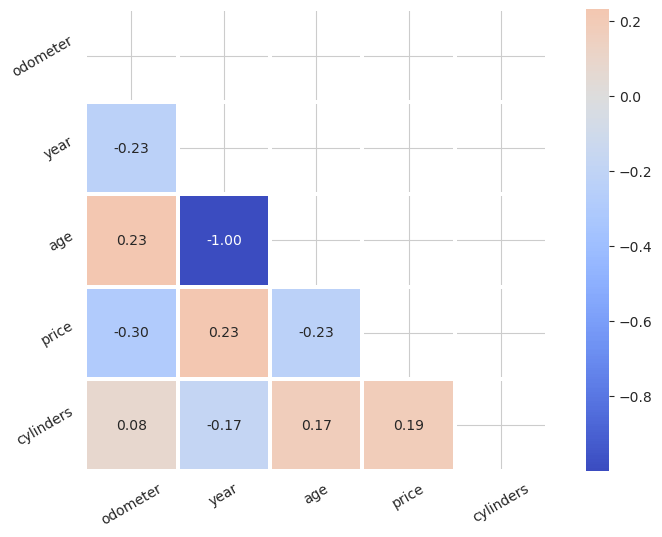

In [65]:
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='coolwarm', ax=None, linewidths=1.5, center=0, annot=True,
            fmt='.2f', square=True, xticklabels=(corr.index), yticklabels=(corr.columns))

plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.grid('off')
plt.show()

In [66]:
df.drop(["posting_year"], axis=1, inplace=True)  #, "month", "day", "date"

In [67]:
df.sort_values(by="posting_date", inplace=True)

In [68]:
df.reset_index(inplace=True)

#### Latitude and Longitude

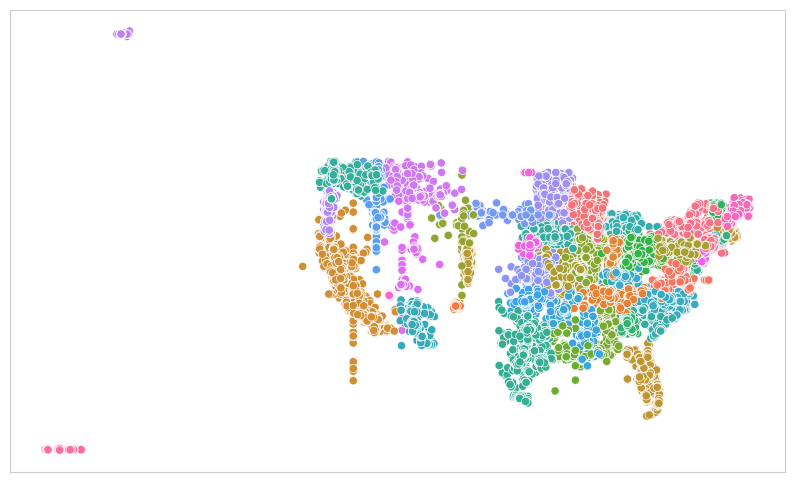

In [69]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='long', y='lat', data=df, hue="state", legend=False);
plt.xlabel("")
plt.xticks([])
plt.ylabel("")
plt.yticks([])
plt.show()

### Object Columns

#### Model

In [70]:
# Get the not desired values from the tail of the value counts in the "model" column
drop_model = df["model"].value_counts(dropna=False).tail(15287).index

# Create a boolean mask to filter rows with not desired values in the 'model' column
mask_drop_model = df['model'].isin(drop_model)

# Drop rows where 'model' column has not desired values
df = df[~mask_drop_model]
df.shape

(165574, 20)

In [71]:
fill_missing(df, "model", ["manufacturer", "fuel", "drive", "size", "type"])

In [72]:
df.drop(["title_status", "condition", "paint_color"], axis=1, inplace=True)

#### Feature Engineering

In [73]:
df["km/year"] = np.where(df["age"] != 0, df["odometer"] / df["age"], 1 / df["age"])
df.drop(df[df["km/year"] == np.inf].index, axis=0, inplace=True)
# df["km/year"].replace([np.inf, -np.inf], 2400000, inplace=True)

def calculate_power(row):
    fuel = row['fuel']
    cylinders = row['cylinders']
    age = row["age"]

    if fuel == 'gas':
        return (3 * 10 * cylinders) / age
    elif fuel == 'diesel':
        return (4 * 10 * cylinders) / age
    elif fuel == 'hybrid':
        return (1 * 10 * cylinders) / age
    elif fuel == 'electric':
        return (2 * 10 * cylinders) / age
    else:
        return None  # Handle unknown fuel types if needed

# Apply the custom function to create the "pow" column
df['pow'] = df.apply(calculate_power, axis=1)

In [74]:
df.reset_index(drop=True, inplace=True)

In [75]:
df_num = df.select_dtypes(include=['int', "float"])
df_num.columns

Index(['index', 'odometer', 'lat', 'long', 'year', 'age', 'price', 'cylinders',
       'km/year', 'pow'],
      dtype='object')

In [76]:
df_obj = df.select_dtypes(include='object')
df_obj.columns

Index(['manufacturer', 'model', 'transmission', 'fuel', 'state', 'drive',
       'size', 'type'],
      dtype='object')

In [77]:
df

,index,manufacturer,model,transmission,fuel,odometer,state,lat,long,year,age,posting_date,price,cylinders,drive,size,type,km/year,pow
0,263405,dodge,durango,automatic,gas,96475.000,ny,42.598,-73.708,2013.000,8.000,2021-04-04 03:00:25-04:00,18997,6.000,rwd,full-size,sedan,12059.375,22.500
1,406887,dodge,dart,automatic,gas,71800.000,wi,42.596,-87.879,2013.000,8.000,2021-04-04 03:03:15-04:00,119,4.000,fwd,mid-size,sedan,8975.000,15.000
2,386356,cadillac,FordE350,automatic,gas,40000.000,va,37.601,-77.656,2011.000,10.000,2021-04-04 03:08:37-04:00,18937,4.000,fwd,compact,sedan,4000.000,12.000
3,255594,lincoln,VPG MV-1,automatic,gas,63687.000,nm,35.111,-106.531,2012.000,9.000,2021-04-04 03:11:17-04:00,22900,8.000,4wd,mid-size,SUV,7076.333,26.667
4,386355,honda,civic lx,automatic,gas,55000.000,va,37.523,-77.445,2013.000,8.000,2021-04-04 03:20:50-04:00,11750,4.000,fwd,mid-size,sedan,6875.000,15.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164659,395186,ford,escape sel fwd gas suv auto,automatic,gas,29657.000,wa,47.200,-122.300,2019.000,2.000,2021-05-04 23:56:13-04:00,19499,6.000,rwd,full-size,SUV,14828.500,90.000
164660,395185,chevrolet,silverado,automatic,gas,129300.000,wa,47.895,-122.199,2003.000,18.000,2021-05-04 23:56:25-04:00,25500,8.000,4wd,full-size,pickup,7183.333,13.333
164661,395183,acura,integra,manual,gas,156000.000,wa,47.988,-122.201,1999.000,22.000,2021-05-04 23:58:48-04:00,5500,4.000,fwd,compact,hatchback,7090.909,5.455
164662,395182,chevrolet,c10,automatic,gas,35000.000,wa,47.687,-122.377,1983.000,38.000,2021-05-04 23:59:22-04:00,16000,8.000,rwd,full-size,truck,921.053,6.316


In [78]:
df.isnull().sum().sort_values(ascending=False)

index           0
age             0
km/year         0
type            0
size            0
drive           0
cylinders       0
price           0
posting_date    0
year            0
manufacturer    0
long            0
lat             0
state           0
odometer        0
fuel            0
transmission    0
model           0
pow             0
dtype: int64

## Modeling

In [79]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_validate

In [80]:
df.describe()

,index,odometer,lat,long,year,age,price,cylinders,km/year,pow
count,164664.000,164664.000,164664.000,164664.000,164664.000,164664.000,164664.000,164664.000,164664.000,164664.000
mean,205284.889,105686.836,38.496,-95.337,2010.120,10.880,14458.538,5.761,12186.298,29.964
std,120082.119,81756.859,5.805,18.470,9.435,9.435,13925.957,1.647,10245.613,35.001
min,4.000,0.000,21.213,-159.720,1925.000,1.000,0.000,0.000,0.000,0.000
25%,101165.750,53000.000,34.836,-113.062,2007.000,5.000,4995.000,4.000,7734.391,12.000
50%,204515.500,99819.000,39.316,-89.815,2012.000,9.000,10395.000,6.000,11141.375,18.462
75%,310067.250,144829.250,42.376,-81.048,2016.000,14.000,19995.000,8.000,15114.617,34.286
max,414469.000,2346897.000,61.481,-68.412,2020.000,96.000,349999.000,12.000,1111111.000,480.000


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164664 entries, 0 to 164663
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype                           
---  ------        --------------   -----                           
 0   index         164664 non-null  int64                           
 1   manufacturer  164664 non-null  object                          
 2   model         164664 non-null  object                          
 3   transmission  164664 non-null  object                          
 4   fuel          164664 non-null  object                          
 5   odometer      164664 non-null  float32                         
 6   state         164664 non-null  object                          
 7   lat           164664 non-null  float64                         
 8   long          164664 non-null  float64                         
 9   year          164664 non-null  float32                         
 10  age           164664 non-null  float64                  

In [82]:
for col in df_obj:
    print(f"{col:<20}:", df[col].nunique())

manufacturer        : 41
model               : 8935
transmission        : 2
fuel                : 4
state               : 51
drive               : 3
size                : 4
type                : 12


In [83]:
df_num.corr()[(df_num.corr()>= 0.9) & (df_num.corr() < 1)].any().any()

False

In [84]:
df_num.corr()[(df_num.corr()<= -0.9) & (df_num.corr() > -1)].any().any()

True

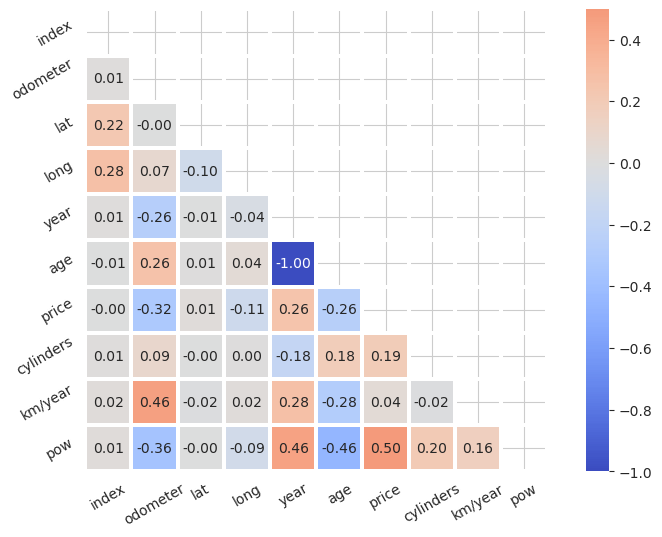

In [85]:
mask = np.triu(np.ones_like(df_num.corr(), dtype=bool))

sns.heatmap(df_num.corr(), mask=mask, cmap='coolwarm', ax=None, linewidths=1.5, center=0, annot=True,
            fmt='.2f', square=True, xticklabels=(df_num.corr().index), yticklabels=(df_num.corr().columns))

plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.grid('off')
plt.show()

In [86]:
df.sample(3)

,index,manufacturer,model,transmission,fuel,odometer,state,lat,long,year,age,posting_date,price,cylinders,drive,size,type,km/year,pow
47613,195853,ram,sport,automatic,gas,130000.000,mi,42.868,-85.863,2011.000,10.000,2021-04-20 10:18:12-04:00,17800,8.000,4wd,full-size,truck,13000.000,24.000
142510,251629,ford,f-150,automatic,gas,10907.000,nm,35.088,-106.562,2020.000,1.000,2021-05-03 14:05:19-04:00,0,8.000,rwd,full-size,truck,10907.000,240.000
133861,51046,dodge,charger,automatic,gas,74175.000,ca,38.669,-121.334,2015.000,6.000,2021-05-02 19:16:07-04:00,18995,8.000,rwd,full-size,truck,12362.500,40.000


In [87]:
def train_val(model, X_train, y_train, X_test, y_test):

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},

    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}

    return pd.DataFrame(scores)

### CatBoost

In [88]:
X = df.drop(["index", "year", "posting_date", "price"], axis=1)  #, "model", "time"
y = df.price

In [89]:
cat = X.select_dtypes("object").columns
cat

Index(['manufacturer', 'model', 'transmission', 'fuel', 'state', 'drive',
       'size', 'type'],
      dtype='object')

In [90]:
import catboost

In [91]:
# cb_learn_rate = 0.006
# n_iterations = 80000
# early_stop_rounds = 400

# opt_catboost_params = {'iterations' : n_iterations,
#                        'learning_rate' : cb_learn_rate,
#                        'depth': 7,
#                        'bootstrap_type' : 'Bernoulli',
#                        'random_strength': 1,
#                        'min_data_in_leaf': 10,
#                        'l2_leaf_reg': 3,
#                        'loss_function' : 'RMSE', 
#                        'eval_metric' : 'RMSE',
#                        'grow_policy' : 'Depthwise',
#                        'max_bin' : 1024, 
#                        'model_size_reg' : 0,
#                        'task_type' : 'GPU',
#                        'od_type' : 'IncToDec',
#                        'od_wait' : 100,
#                        'metric_period' : 500,
#                        'verbose' : 500,
#                        'subsample' : 0.8,
#                        'od_pval' : 1e-10,
#                        'max_ctr_complexity' : 8,
#                        'has_time': False,
#                        'simple_ctr' : 'FeatureFreq',
#                        'combinations_ctr': 'FeatureFreq',
#                        'random_seed' : 13}

In [92]:
# cb_reg = CatBoostRegressor(**opt_catboost_params)

# cb_reg.fit(X_train, y_train, eval_set=(X_val, y_val), 
#            use_best_model=True, plot=True, 
#            early_stopping_rounds=early_stop_rounds)

In [93]:
from catboost import CatBoost

# cb = CatBoost(params={'iterations':100, 'verbose':10, 'loss_function':'RMSE', 'task_type':"GPU", 'devices':'0'})

In [94]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [95]:
# cb.fit(X_train, y_train, plot=True)
# cb.set_feature_names(X.feature_names)

In [96]:
# train_preds = cb.predict(X_train)
# val_preds = cb.predict(X_val)

In [97]:
from catboost.utils import eval_metric

# print("Train R2 : %.2f"%eval_metric(Y_train, train_preds, "R2")[0])
# print("Validation  R2 : %.2f"%eval_metric(Y_val, val_preds, "R2")[0])

In [98]:
from catboost import utils

gpu_cnt = utils.get_gpu_device_count()

print("Number of GPU Count : ", gpu_cnt)

Number of GPU Count :  0


Error 35 (CUDA driver version is insufficient for CUDA runtime version) ignored while obtaining device count


In [99]:
# cb.shrink(ntree_end=50)

# train_preds = cb.predict(X_train)
# val_preds = cb.predict(X_val)

# print("Train R2 : %.2f"%eval_metric(Y_train, train_preds, "R2")[0])
# print("Validation  R2 : %.2f"%eval_metric(Y_val, val_preds, "R2")[0])

**CatBoost Regressor**

In [100]:
# from catboost import CatBoostRegressor

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# cb = CatBoostRegressor(iterations=100, verbose=10, task_type="GPU", devices="0")

# cb.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=5, plot=True, 
#        save_snapshot=True, snapshot_file="cb_snapshots.temp", snapshot_interval=1)

# cb.set_feature_names(X.feature_names)

# train_preds = cb.predict(X_train)
# val_preds = cb.predict(X_val)


# from catboost.utils import eval_metric

# print("Train R2 : %.2f"%cb.score(X_train, y_train))
# print("\nValidation  R2 : %.2f"%cb.score(X_val, y_val))

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="ford": Cannot convert 'b'ford'' to float

In [101]:
cb.get_all_params()

CatBoostError: There is no trained model to use get_all_params(). Use fit() to train model. Then use this method.

In [ ]:
# 'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 100, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.03, 'score_function': 'Cosine', 'task_type': 'GPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 64

#### Grid Search

In [103]:
# cb = CatBoost()

# params = {
#             'iterations':[10, 50],
#             'learning_rate':[0.01, 0.1],
#             'bootstrap_type':['Bayesian', 'Bernoulli', 'No']
# }

# search_results = cb.grid_search(params, X_train, y_train, cv=5)

# print("\nBest Params : ", search_results['params'])

# train_preds = cb.predict(X_train)
# val_preds = cb.predict(X_val)

# print("Train R2 : %.2f"%eval_metric(y_train, train_preds, "R2")[0])
# print("\nValidation  R2 : %.2f"%eval_metric(y_val, val_preds, "R2")[0])

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="ford": Cannot convert 'b'ford'' to float

In [ ]:
# cv_results = pd.DataFrame(search_results["cv_results"])

# cv_results.head()

In [104]:
# cb = CatBoostRegressor()

# params = {
#             'iterations':[10, 50],
#             'learning_rate':[0.01, 0.1],
#             'bootstrap_type':['Bayesian', 'No']
# }

# search_results = cb.grid_search(params, X_train, y_train, cv=5, )

# print("\nBest Params : ", search_results['params'])

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="ford": Cannot convert 'b'ford'' to float

#### Pool

In [144]:
from catboost import Pool

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat.tolist())
val_pool = Pool(X_val, y_val, cat.tolist())

cb = catboost.train(pool=train_pool, eval_set=val_pool, plot=True, early_stopping_rounds=15,
                    params={
                        'iterations': 8000,
                        'verbose': 50,
                        'loss_function':'RMSE',
                         'one_hot_max_size': 500,
                         'min_data_in_leaf': 1,
                         'learning_rate': 0.03,
                         'task_type': 'CPU'
                                                 })

print()
print(cb)

cb.set_feature_names(list(X.columns))

# cb.shrink(ntree_end=70)

train_preds = cb.predict(train_pool)
val_preds = cb.predict(val_pool)

# from catboost.utils import eval_metric

# print("Train R2 : %.2f"%eval_metric(y_train, train_preds, "R2")[0])
# print("\nValidation  R2 : %.2f"%eval_metric(y_val, val_preds, "R2")[0])

from sklearn.metrics import r2_score

# Calculate R2 scores using scikit-learn's r2_score function
train_r2 = r2_score(y_train, train_preds)
val_r2 = r2_score(y_val, val_preds)

# Print the R2 scores
print("Train R2 : %.2f" % train_r2)
print("Validation R2 : %.2f" % val_r2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 13737.5692412	test: 13900.6443181	best: 13900.6443181 (0)	total: 63.9ms	remaining: 8m 31s
50:	learn: 10551.6153394	test: 10642.4701941	best: 10642.4701941 (50)	total: 2.53s	remaining: 6m 35s
100:	learn: 10039.7395565	test: 10081.8463823	best: 10081.8463823 (100)	total: 4.71s	remaining: 6m 8s
150:	learn: 9871.9420565	test: 9911.0742697	best: 9911.0742697 (150)	total: 7.02s	remaining: 6m 5s
200:	learn: 9756.1738494	test: 9805.4421606	best: 9805.4421606 (200)	total: 9.33s	remaining: 6m 2s
250:	learn: 9661.1260206	test: 9725.7805562	best: 9725.7805562 (250)	total: 11.6s	remaining: 5m 58s
300:	learn: 9582.0213499	test: 9659.1563082	best: 9659.1563082 (300)	total: 13.9s	remaining: 5m 55s
350:	learn: 9504.0876700	test: 9603.7682315	best: 9603.7682315 (350)	total: 16.2s	remaining: 5m 52s
400:	learn: 9433.0278545	test: 9549.9536617	best: 9549.9536617 (400)	total: 18.5s	remaining: 5m 50s
450:	learn: 9372.9028053	test: 9507.5378177	best: 9507.5378177 (450)	total: 20.7s	remaining: 5m 46s

In [106]:
cb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 700,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBord

In [110]:
# from catboost import Pool
# from catboost.utils import eval_metric

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# train_pool = Pool(X_train, y_train, cat.tolist())
# val_pool = Pool(X_val, y_val, cat.tolist())

# cb = CatBoost({'verbose':100, 'iterations':5000, 'loss_function':'RMSE', 'task_type':'GPU', 'devices':'0'})

# cb.fit(train_pool, eval_set=val_pool, early_stopping_rounds=15, plot=True, 
#        save_snapshot=True, snapshot_file="catboost_snapshots.temp",snapshot_interval=1)

# cb.set_feature_names(list(X.columns))

# train_preds = cb.predict(train_pool)
# val_preds = cb.predict(val_pool)

# # print("Train R2 : %.2f"%eval_metric(y_train, train_preds, "R2")[0])
# # print("\nValidation  R2 : %.2f"%eval_metric(y_val, val_preds, "R2")[0])

# from sklearn.metrics import r2_score

# # Calculate R2 scores using scikit-learn's r2_score function
# train_r2 = r2_score(y_train, train_preds)
# val_r2 = r2_score(y_val, val_preds)

# # Print the R2 scores
# print("Train R2 : %.2f" % train_r2)
# print("Validation R2 : %.2f" % val_r2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: /src/catboost/catboost/cuda/cuda_lib/cuda_manager.cpp:201: Condition violated: `State == nullptr'

In [121]:
fea_imp = cb.feature_importances_
sorted_fea_imp = fea_imp.argsort()[::-1]

plt.barh(range(len(sorted_fea_imp)), 
         fea_imp[sorted_fea_imp],  
        color='purple')
plt.yticks(range(len(sorted_fea_imp)), 
           [X.columns[i] for i in sorted_fea_imp])
plt.xlabel("CatBoost Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
# cb1.compare(cb2, data=Pool(X_val,y_val), metrics=["R2", "RMSE", "MAE"])

### ANN Model

In [ ]:
X = df.drop(["index", "model", "year", "posting_date", "price"], axis=1)  #, "time"
y = df.price

In [ ]:
X.columns

In [ ]:
cat = X.select_dtypes("object").columns
cat

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

In [ ]:
X_train.columns

In [ ]:
X_test.columns

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder  #, LabelEncoder
# from sklearn import preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler  #, RobustScaler

In [ ]:
from sklearn.compose import make_column_transformer

In [ ]:
ohe_enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
column_trans_minmax = make_column_transformer((ohe_enc, cat), remainder=MinMaxScaler())
column_trans_minmax

In [ ]:
X_train_mm = column_trans_minmax.fit_transform(X_train)
X_test_mm = column_trans_minmax.transform(X_test)

In [ ]:
ohe_enc = OneHotEncoder(handle_unknown="ignore", sparse=False)  #, unknown_value=-1
column_trans_standart = make_column_transformer((ohe_enc, cat), remainder=StandardScaler())

In [ ]:
X_train_st = column_trans_standart.fit_transform(X_train)
X_test_st = column_trans_standart.transform(X_test)

In [ ]:
X_train_mm.shape  #X_train_st.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
from tqdm import tqdm
# from keras_tqdm import TQDMCallback
from tqdm.keras import TqdmCallback

In [ ]:
# from tensorflow.keras import backend as K

In [ ]:
# def rmse_func(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
SEED = 42
tf.random.set_seed(SEED)

modelANN = Sequential()

modelANN.add(Dense(200, activation="relu", input_dim=X_train_mm.shape[1]))
modelANN.add(Dense(200, activation="relu"))
modelANN.add(Dense(180, activation="relu"))
modelANN.add(Dense(180, activation="relu"))
modelANN.add(Dense(160, activation="relu"))
modelANN.add(Dense(160, activation="relu"))
modelANN.add(Dense(140, activation="relu"))
modelANN.add(Dense(120, activation="relu"))
modelANN.add(Dense(80, activation="relu"))
modelANN.add(Dense(60, activation="relu"))
modelANN.add(Dense(60, activation="relu"))
modelANN.add(Dense(40, activation="relu"))
modelANN.add(Dense(40, activation="relu"))
modelANN.add(Dense(20, activation="relu"))
modelANN.add(Dense(10, activation="relu"))
modelANN.add(Dense(4, activation="relu"))
modelANN.add(Dense(4, activation="relu"))
modelANN.add(Dense(1, activation="linear"))  #

modelANN.summary()

modelANN.compile(optimizer=Adam(learning_rate=0.03), loss="mae")  #rmse_func
                                #, metrics=[tf.keras.metrics.MeanSquaredError()]"mse", "mae"

In [ ]:
earlyStoppingCallback = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)  #val_mean_squared_error

modelANN.fit(x=X_train_mm,
          y=y_train,
          validation_split=0.2,
          batch_size=1024,
          epochs=1000,
          verbose=0,
          callbacks=[earlyStoppingCallback, TqdmCallback()])

In [ ]:
loss_model = pd.DataFrame(modelANN.history.history)
loss_model.plot();

In [ ]:
y_pred = modelANN.predict(X_test_mm)

In [ ]:
train_val(modelANN, X_train_mm, y_train, X_test_mm, y_test)

#### Final Model

In [ ]:
X_train.columns

In [ ]:
X_new = df[['age', 'cylinders', 'fuel', 'odometer', 'long', 'manufacturer', 'model', 'lat']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, random_state=101)

In [ ]:
cat_new = X_new.select_dtypes("object").columns

ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat_new),
                                       remainder='passthrough')

operations = [("OrdinalEncoder", column_trans),
              ("model_final",
               XGBRegressor(colsample_bytree=0.9,  #1
                            learning_rate=0.04,  #0.3
                            max_depth=12,  #6
                            n_estimators=15000,  #700
                            subsample=1,  #0.8
                            max_leaves=28,
                            objective='reg:squarederror',
                            random_state=42,
                            tree_method='gpu_hist',
#                             sampling_method="gradient_based",  #Used only by `gpu_hist` tree method.`uniform`, `gradient_based`
#                             grow_policy="lossguide"  #"depthwise"
#                             booster="gbtree"  #gbtree,
                                                #dart:performs dropouts. Use preds=bst.predict(dtest, iteration_range=(0, num_round)) for test set
                           ))]

model_p_f = Pipeline(steps=operations)
model_p_f.fit(X_train, y_train)  #, eval_metric="rmse", verbose=True, early_stopping_rounds=10, eval_set=eval_set

train_val(model_p_f, X_train, y_train, X_test, y_test)

In [ ]:
# Final Model Results:

# 	train	test
# R2	0.83	0.78
# mae	3807.07	4148.53
# mse	36898028.85	45882339.25
# rmse	6074.37	6773.65

## Prediction

### Preprocess of Test Set

In [ ]:
test.describe()

In [ ]:
test.info()

In [ ]:
X_new.columns

In [ ]:
# Convert the "posting_date" column to datetime with the corrected format (including time zone offset)
test['posting_date'] = pd.to_datetime(test['posting_date'], utc=True)

# Set the time zone to the desired one, for example, 'America/New_York'
test['posting_date'] = test['posting_date'].dt.tz_convert('America/New_York')  # UTC -04:00

test['posting_year'] = test['posting_date'].dt.year
test["age"] = test["posting_year"] - test["year"]

In [ ]:
test["posting_date"].min(), test["posting_date"].max(), test["posting_date"].max() - test["posting_date"].min()

#### Transmission

In [ ]:
test["transmission"].value_counts(dropna=False)

In [ ]:
test['transmission'] = test['transmission'].replace('other', np.NaN)

In [ ]:
fill_missing(test, "transmission", ["manufacturer", "model", "drive", "type"])

In [ ]:
test["transmission"].isnull().sum()

#### Fuel

In [ ]:
test["fuel"].value_counts(dropna=False)

In [ ]:
test['fuel'] = test['fuel'].replace('other', np.NaN)

In [ ]:
fill_missing(test, "fuel", "model")

In [ ]:
test["fuel"].isnull().sum()

#### Type

In [ ]:
test["type"].value_counts(dropna=False)

In [ ]:
test['type'] = test['type'].replace('other', np.NaN)

In [ ]:
fill_missing(test, "type", ["manufacturer", "model", "fuel", "cylinders"])

In [ ]:
test["type"].isnull().sum()

#### Cylinders

In [ ]:
# Use a regular expression to extract the numeric part from the "cylinders" column
test['cylinders'] = test['cylinders'].str.replace(r'(\d+)\s*cylinders', r'\1', regex=True)

# Replace "other" with 1
test['cylinders'] = test['cylinders'].replace('other', np.nan)

# Convert the "cylinders" column to numeric type
test['cylinders'] = pd.to_numeric(test['cylinders'], errors='coerce')

# The "cylinders" column now contains the desired numeric values and NaN for missing values

In [ ]:
test.loc[test['fuel'] == 'electric', 'cylinders'] = 0

In [ ]:
fill_missing(test, "cylinders", ["manufacturer", "model", "fuel", "drive"])

In [ ]:
test["cylinders"].isnull().sum()

#### Latitude and Longitude

In [ ]:
lats = pd.DataFrame(test.groupby('state')['lat'].count())
lats = lats.reset_index()
longs = pd.DataFrame(test.groupby('state')['long'].count())
longs = longs.reset_index()

plt.figure(figsize=(16, 20))

plt.subplot(211)
plt.boxplot(lats,
#             whis=2.5
           )

plt.subplot(212)
plt.boxplot(longs,
#             whis=2.5
           )

plt.show()

In [ ]:
# Group by the "state" column and calculate the mode of "lat" and "long" for each state group
state_mode_lat = test.groupby('state')['lat'].transform(lambda x: x.mode().iloc[0])
state_mode_long = test.groupby('state')['long'].transform(lambda x: x.mode().iloc[0])

# Fill missing values in "lat" and "long" columns with the mode of each state group
test['lat'] = test['lat'].fillna(state_mode_lat)
test['long'] = test['long'].fillna(state_mode_long)

In [ ]:
test[["lat", "long"]].isnull().sum()

#### Manufacturer

In [ ]:
fill_missing(test, "manufacturer", "model")

In [ ]:
test["manufacturer"].isnull().sum()

#### Drive

In [ ]:
fill_missing(test, "drive", ["manufacturer", "model", "fuel", "cylinders"])

In [ ]:
test["drive"].isnull().sum()

#### Size

In [ ]:
fill_missing(test, "size", ["manufacturer", "model", "type"])

In [ ]:
test["size"].isnull().sum()

In [ ]:
sns.heatmap(test.isnull(), yticklabels=False, cbar=False, cmap='viridis');
plt.xticks(rotation=45)
plt.show()

In [ ]:
test.describe()

In [ ]:
# test.drop(test[test['odometer'] > 1000000].index, axis=0, inplace=True)

In [ ]:
test.loc[test['odometer'] > 1000000, 'odometer'] = 1000000

In [ ]:
# test.drop(test[test['year'] < 1948].index, axis=0, inplace=True)

In [ ]:
test.loc[test['year'] < 1948, 'year'] = 1948

In [ ]:
# test.drop(test[test["age"] < 0].index, axis=0, inplace=True)

In [ ]:
test['age'] = test['age'].replace(-1, 0)

In [ ]:
# test.drop(test[test['age'] > 68].index, axis=0, inplace=True)

In [ ]:
# test.loc[test['age'] > 67, 'age'] = 67

In [ ]:
corr = test[['odometer', 'year', 'age', 'cylinders']].corr()

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='coolwarm', ax=None, linewidths=1.5, center=0, annot=True,
            fmt='.2f', square=True, xticklabels=(corr.index), yticklabels=(corr.columns))

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.grid('off')
plt.show()

In [ ]:
test.columns

In [ ]:
test.drop(["posting_year", "title_status", "condition", "paint_color"], axis=1, inplace=True)

In [ ]:
# test.sort_values(by="posting_date", inplace=True)

In [ ]:
test.reset_index(inplace=True)

In [ ]:
test.isnull().sum().sort_values(ascending=False)

In [ ]:
test.shape, submission.shape

In [ ]:
X_new.columns

In [ ]:
test.columns

In [ ]:
test["pred"] = model_p_f.predict(test[X_new.columns])

In [ ]:
test["pred"].describe()

In [ ]:
test.info()

In [ ]:
plt.figure(figsize=(14, 8))
sns.histplot(x='pred', data=test, bins=35, legend=False);
plt.xlabel("Predictions")
plt.show()

In [ ]:
test[test["pred"] < 0]

In [ ]:
min_pred = test[test["pred"] > 0].groupby(["fuel", "cylinders"])["pred"].min()

test = test.merge(min_pred.reset_index(), on=["fuel", "cylinders"], how="left", suffixes=("", "_min"))

replace_negative = lambda row: row["pred_min"] if row["pred"] < 0 else row["pred"]

# Apply the lambda function to update the "pred" column
test["pred"] = test.apply(replace_negative, axis=1)

# Drop the auxiliary columns used for merging
test.drop(columns=["pred_min"], inplace=True)

In [ ]:
test.info()

## Submission

In [ ]:
submission

In [ ]:
submission = test[["id", "pred"]]
submission

In [ ]:
submission.info()

In [ ]:
submission.describe()

In [ ]:
submission.to_csv("submission.csv", index=False)